# Small Data Mini Classification Project: Life Expectancy
Author: Ishan Porwal

## Introduction
For this project, I wanted to classify something that required both categorial factors and numerical factors. While searching for datasets, I came across this dataset on life expectancy. I thought that it'd be interesting to look into some of the factors that might allow you predict someone's life expectancy such as information about the country they live in. For my model, I decided to clean the data by dropping some columns. I didn't really wnat to separate by country because there was a relatively low ratio between the number of different countries and different data points per country. Additionally, the data for "Hepatitis B", "Measles", "Polio", "Diphtheria","HIV/AIDS", "infant deaths", and "under-five deaths" seemed too redundant and intuitively linked to life expectancy. I wanted to focus on factors like GDP, BMI, and schooling instead since they might provide a more hollistic view.

Here is a link to the dataset: https://www.kaggle.com/datasets/amirhosseinmirzaie/countries-life-expectancy/data

In [26]:
# import necessary modules
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# load and read data
df = pd.read_csv('life_expectancy.csv')

# cleaning data and converting categorical values to binary
df = df.drop(["Country", "Hepatitis B", "Measles", "Polio", "Diphtheria", 
              "HIV/AIDS", "infant deaths", "under-five deaths"], axis=1)
df.head()

,Year,Status,Population,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
0,2015,Developing,33736494.0,8.16,584.259210,19.1,17.2,0.01,10.1,65.0
1,2014,Developing,327582.0,8.18,612.696514,18.6,17.5,0.01,10.0,59.9
2,2013,Developing,31731688.0,8.13,631.744976,18.1,17.7,0.01,9.9,59.9
3,2012,Developing,3696958.0,8.52,669.959000,17.6,17.9,0.01,9.8,59.5
4,2011,Developing,2978599.0,7.87,63.537231,17.2,18.2,0.01,9.5,59.2


# Motivation
The goal for this project is to be able to predict the target variable life expectancy based on the given data and compare it to the known life expectancy. I want to be able to classify high or low life expectancy based on some derived threshold. Since this is a binary classification, an accuracy of 85-90% would be considered strong and valuable. Aside from accuracy, I'm also going to be evaluating my model based on loss, root mean squared error, precision, and recall. If my loss and error are being minimized while my accuracy, precision, and recall are being maximized, we model is working well.

Beyond just manipulating, training, and evaluating the data, I also want to take into account the implications of this approach. As for risks, life expectancy obviously isn't going to be the same across an entire nation, local factors are at play as well such as regional socioeconomic and healthcare conditions. Country-wide data can fail to account for these resulting in inaccurate generalizations. Additionally, if certain regions or demogrpahics are overrepresented while others are underrepresented in the dataset, the model could have biased predictions.

Some of the stakeholders for my models like mine include policymakers and governments. These individuals or entities could use life expectancy models to design health interventions, allocate budgets, or even prioritize certain regions/countries for aid. The general public can also benefit from this information as they can push for changes to address hinderances to life expectancy in their nations as a result of an analysis of the factors.

# Implementation, Visualization, and Interpretation
All of the factors are numerical except for development status of the countries which is categorical. In order to run my machine learning algorithm, I had to create dummy columns for status to convert this into a binary indicator. I also noticed that some of the entries in the dataset had null values so I had to remove these.

Then, to analyze the impact each of the remaining factors may have on the target variable, I plotted their values against life expectancy.

What each of the factors mean:
 - Year - the year the data was taken
 - Population - population of the country
 - Total expenditure - ratio of government medical-health expenses to total government expenses in percentage
 - GDP - gross domestic product of country
 - BMI - average body mass index of entire population in country
 - thinness 1-19 years - prevalance of thinness among people 19 years old in percentage in country
 - Alcohol - liters of alcohol consumption among people over 15 years old in country
 - Schooling - the average number of years that people study in country

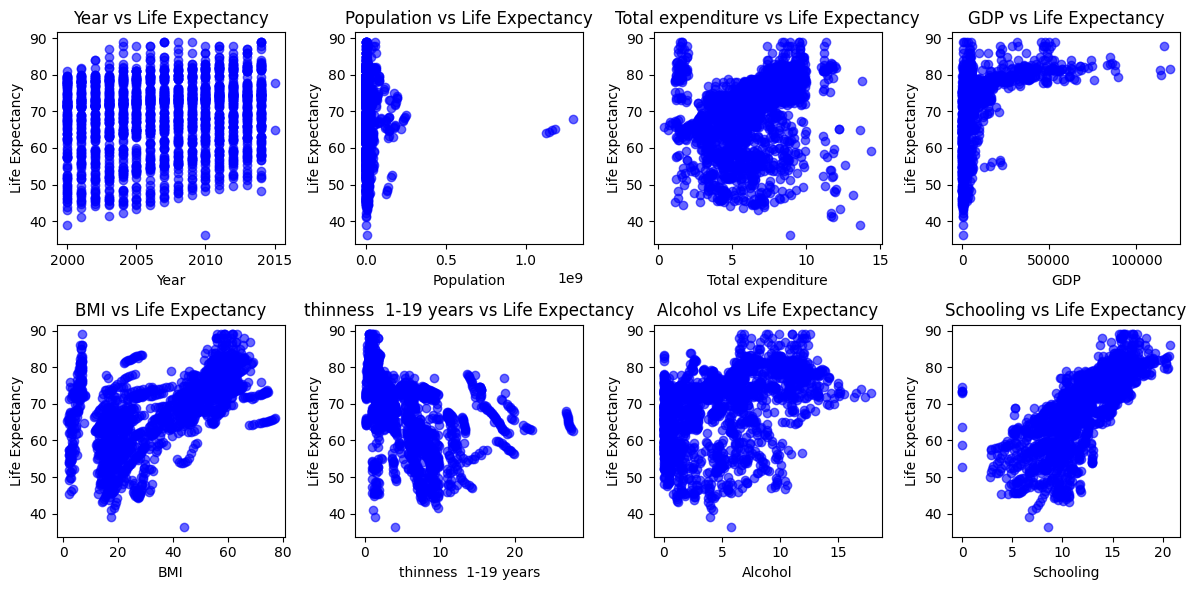

In [27]:
# cleaning up data
df = df.dropna()
df = pd.get_dummies(df, columns=["Status"], drop_first=True)

# make subplots relating factors and life expectancy
factors = ['Year', 'Population', 'Total expenditure', 'GDP', 'BMI', 'thinness  1-19 years', 'Alcohol', 'Schooling']

# Create subplots: 4 rows, 4 columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axes = axes.flatten()

# Plot each factor
for i, factor in enumerate(factors):
    axes[i].scatter(df[factor], df['Life expectancy'], color='blue', alpha=0.6)
    axes[i].set_title(f'{factor} vs Life Expectancy')
    axes[i].set_xlabel(factor)
    axes[i].set_ylabel('Life Expectancy')

# Hide any unused subplots (if there are any)
for j in range(len(factors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the graphs above, we can make some observations about relationships between the factors and life expectancy. For example, GDP of the country and life expectancy seem to have a positive correlation, as do BMI, schooling, and surprisingly alcohol. However, according to the United Nations Food and Agriculture Organization (FAO), most developing countries indeed have lower alcohol consumption than most developed countries. This is mainly due to widespread poverty in many developing countries, just an interesting thing to note.

Before running my model, I separated the data into my training and testing data with a 70/30 split and defined my inputs and outputs. The inputs were all of the factors except the target variable while the output was life expectancy. I then scaled the data to normalzize the features for faster convergance and converted the values to tensors for compatibility with PyTorch.

In [8]:
# splitting testing and training data
X = df.drop("Life expectancy", axis=1)
y = df["Life expectancy"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# get mean to set threshold
print("Life Expectancy Statistics:")
print(y.describe())

# scaling and converting data to tensors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

Life Expectancy Statistics:
count    2026.000000
mean       68.820089
std         9.910989
min        36.300000
25%        62.700000
50%        71.600000
75%        75.575000
max        89.000000
Name: Life expectancy, dtype: float64


I also calculated some statistics to get a better idea of the life expectancies I was working with/against. The mean was 68.8, so I used this as my threshold for high versus low life expectancy.

Below are the helper functions I used to train, test, and evaluate my model as well as create my visualizations.

In [9]:
def train_model(model, criterion, optimizer, num_epochs=1000):
    """
    Trains the specified model using the given loss criterion and optimizer.

    Args:
        model: The neural network model to be trained.
        criterion: The loss function used to evaluate the model's performance.
        optimizer: The optimization algorithm to update the model's weights.
        num_epochs: An optional integer specifying the number of training epochs (default is 1000).

    Returns:
        A tuple containing two lists: 
            - train_losses: A list of training loss values over epochs.
            - test_losses: A list of testing loss values over epochs.
    """
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        # forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # evaluating model
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        # printing epoch stats
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    return train_losses, test_losses

def evaluate_model(model, threshold=68.8):
    """
    Evaluates the performance of the specified model and calculates classification metrics.

    Args:
        model: The trained neural network model to evaluate.
        threshold: A float value used to classify predictions into high/low life expectancy (default is 68.8).

    Returns:
        A tuple containing:
            - test_predictions: The model's predicted life expectancy values for the test set.
            - y_test_class: The actual binary classification for the test set.
            - test_predictions_class: The predicted binary classification for the test set.
    """
    model.eval()
    with torch.no_grad():
        # convert model predictions from tensors to numpy arrays
        train_predictions = model(X_train_tensor).numpy()
        test_predictions = model(X_test_tensor).numpy()
    # calculate root mean squared error for training and testing
    train_mse = np.mean((train_predictions - y_train.values.reshape(-1, 1))**2)
    test_mse = np.mean((test_predictions - y_test.values.reshape(-1, 1))**2)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    # binary classification of high/low life expectancy
    train_predictions_class = (train_predictions >= threshold).astype(int)
    test_predictions_class = (test_predictions >= threshold).astype(int)
    y_train_class = (y_train.values >= threshold).astype(int)
    y_test_class = (y_test.values >= threshold).astype(int)
    return test_predictions, y_test_class, test_predictions_class

def classification_metrics(y_test_class, test_predictions_class):
    """
    Calculates and displays classification metrics, including accuracy, precision, and recall.

    Args:
        y_test_class: The actual binary classification for the test set.
        test_predictions_class: The predicted binary classification for the test set.

    Returns:
        A tuple containing:
            - accuracy: The accuracy of the model's predictions.
            - precision: The precision of the model's predictions.
            - recall: The recall of the model's predictions.
    """
    # generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_class, test_predictions_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    # calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test_class, test_predictions_class)
    precision = precision_score(y_test_class, test_predictions_class)
    recall = recall_score(y_test_class, test_predictions_class)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return accuracy, precision, recall

def plot_losses(train_losses, test_losses, nn):
    """
    Plots the training and testing loss over epochs for the specified neural network model.

    Args:
        train_losses: A list of training loss values over epochs.
        test_losses: A list of testing loss values over epochs.
        nn: A string representing the name of the neural network model.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Loss during Training and Testing ({nn})')
    plt.legend()
    plt.yscale('log')
    plt.show()

def plot_actual_vs_predicted(y_test, test_predictions, nn):
    """
    Plots the actual vs predicted life expectancy values for the specified neural network model.

    Args:
        y_test: The actual life expectancy values for the test set.
        test_predictions: The predicted life expectancy values for the test set.
        nn: A string representing the name of the neural network model.
    """
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(y_test, test_predictions, c=test_predictions, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Predicted Life Expectancy')  # Add a color bar for reference
    plt.xlabel("Actual Life Expectancy")
    plt.ylabel("Predicted Life Expectancy")
    plt.title(f"Actual vs Predicted Life Expectancy ({nn})")
    plt.grid(True)
    plt.show()

Below are the Neural Network functions I created using PyTorch. The first is my intiial simple 3 layer feed forward neural network. The next is my second iteration, a deeper 7 layer feed forward neural network. The activation function used is ReLU.

In [10]:
#----------------Defining Neural Network Functions------------------

# simple 3 layer feed forward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        # applying ReLU activation function
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# deeper 7 layer feed forward neural network
class DeeperNN(nn.Module):
    def __init__(self, input_size):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)
    def forward(self, x):
        # applying ReLu activation function
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

I made sure my code was very modular so the iterations were easy to create and manipulate basically only using the helper functions. All three iterations use the exact same format, with only the model and lambda value changing.

Epoch [100/1000], Train Loss: 4334.6011, Test Loss: 4274.2485
Epoch [200/1000], Train Loss: 2536.8049, Test Loss: 2558.8347
Epoch [300/1000], Train Loss: 900.3500, Test Loss: 931.7707
Epoch [400/1000], Train Loss: 350.7338, Test Loss: 354.2914
Epoch [500/1000], Train Loss: 201.8690, Test Loss: 204.8525
Epoch [600/1000], Train Loss: 152.2993, Test Loss: 157.1122
Epoch [700/1000], Train Loss: 127.5058, Test Loss: 132.7650
Epoch [800/1000], Train Loss: 111.8428, Test Loss: 116.9827
Epoch [900/1000], Train Loss: 100.6442, Test Loss: 105.5027
Epoch [1000/1000], Train Loss: 91.8815, Test Loss: 96.3988


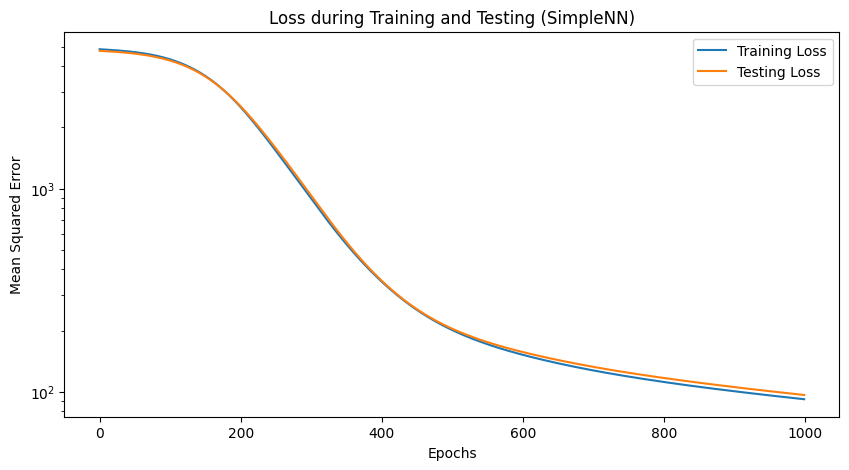

Train RMSE: 9.58
Test RMSE: 9.82


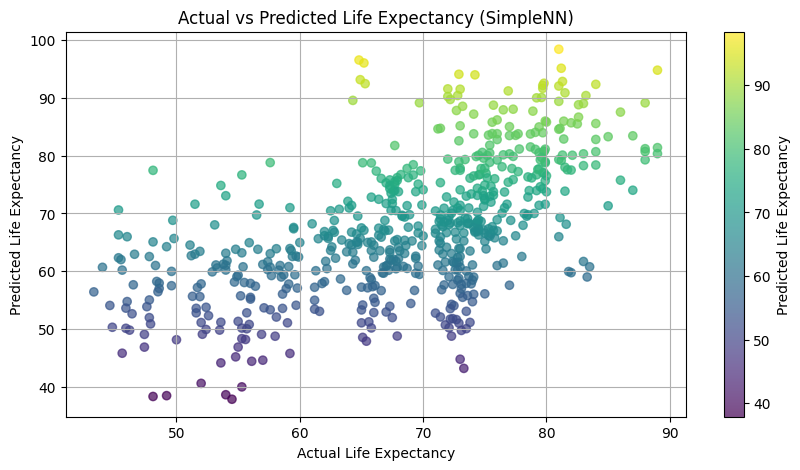

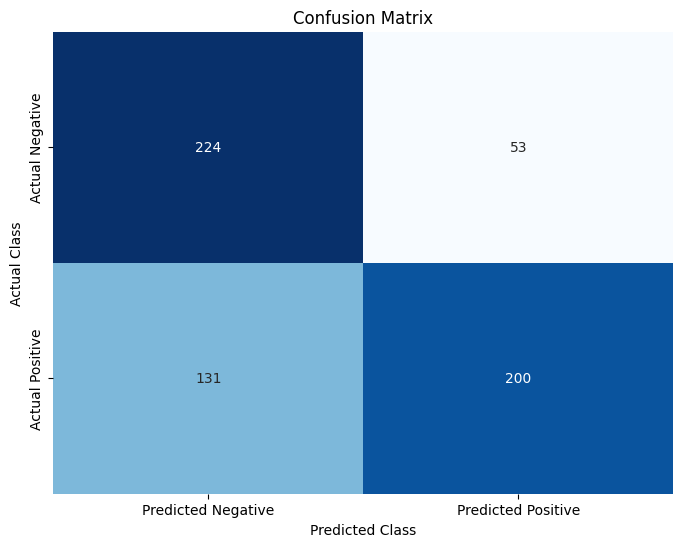

Accuracy: 0.6974
Precision: 0.7905
Recall: 0.6042


In [11]:
#--------------------------- First Model Iteration: Simple 3 Layer-----------------------------

input_size = X_train.shape[1]
model = SimpleNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "SimpleNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "SimpleNN")

# calculate and display classification metrics
S_accuracy, S_precision, S_recall = classification_metrics(y_test_class, test_predictions_class)

The loss for the first model iteration decreased from over 4000 to 96 over 1000 epochs representing a significant improvement in the model's learning. Based on the graph of loss, the model initially has high loss, then has a learning phase where the loss signifiicantly decreases, then starts to plateau. The testing loss always remains lower than the training loss which makes sense since it's being evaluated against data it hasn't seen before. The root mean squared error for testing was 9.82 which means that on average, the model's predictions deviate from the actual life expectancy by 9.82 years. This isn't the best considering the life expectancies range from 36.3 to 89. This is also reflected by the values for accuracy, precision, and recall. However, we'll evaluate these separately.

The heatmap of the actual versus predicted life expectancies also visualizes the model's accuracy. The further the data points are from the linear line of y=x, the worse the predictions are. In other words, a linear correlation between the actual and predicted life expectancies is desirable. In one case, the model predicts someone with an actual life expectnacy of about 48 to have a life expectnacy of 78.

Below is where I conducted the second model iteration with a 7 layer deeper neural network. All of the parameters and process remain the same other than the addition of layers within the neural network.

Epoch [100/1000], Train Loss: 496.4686, Test Loss: 422.1134
Epoch [200/1000], Train Loss: 128.3594, Test Loss: 126.5795
Epoch [300/1000], Train Loss: 88.4984, Test Loss: 91.2071
Epoch [400/1000], Train Loss: 63.4913, Test Loss: 66.5299
Epoch [500/1000], Train Loss: 45.5405, Test Loss: 48.3993
Epoch [600/1000], Train Loss: 33.1606, Test Loss: 36.0302
Epoch [700/1000], Train Loss: 25.7278, Test Loss: 28.9395
Epoch [800/1000], Train Loss: 21.7029, Test Loss: 25.4805
Epoch [900/1000], Train Loss: 19.5117, Test Loss: 23.8642
Epoch [1000/1000], Train Loss: 18.1067, Test Loss: 22.9194


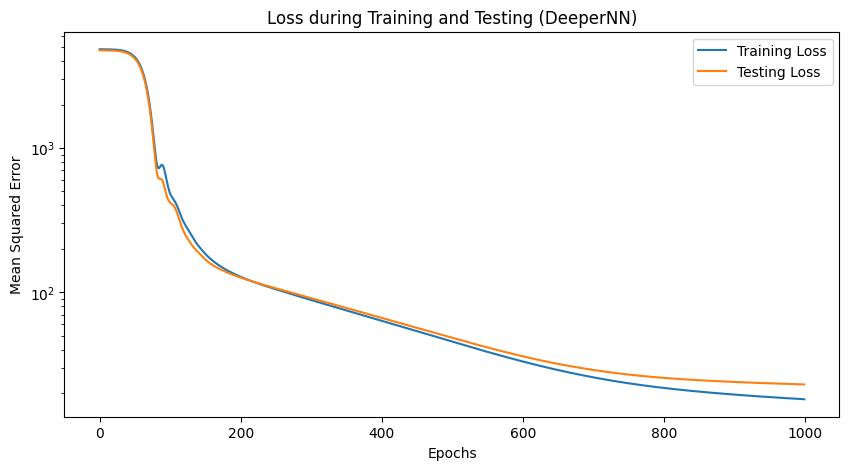

Train RMSE: 4.25
Test RMSE: 4.79


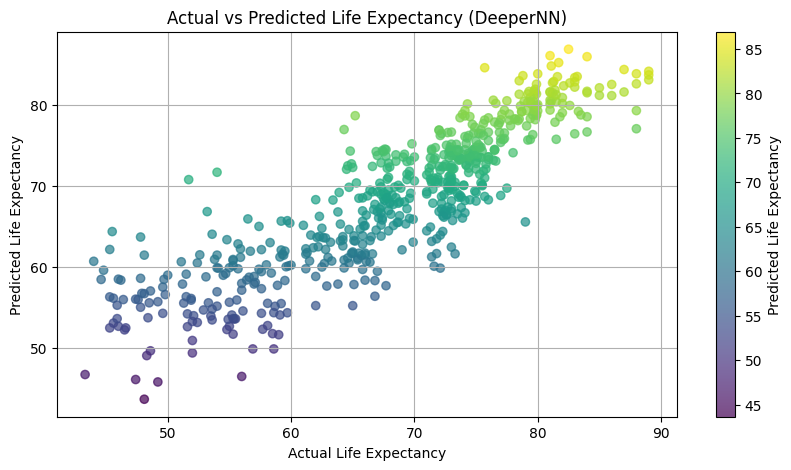

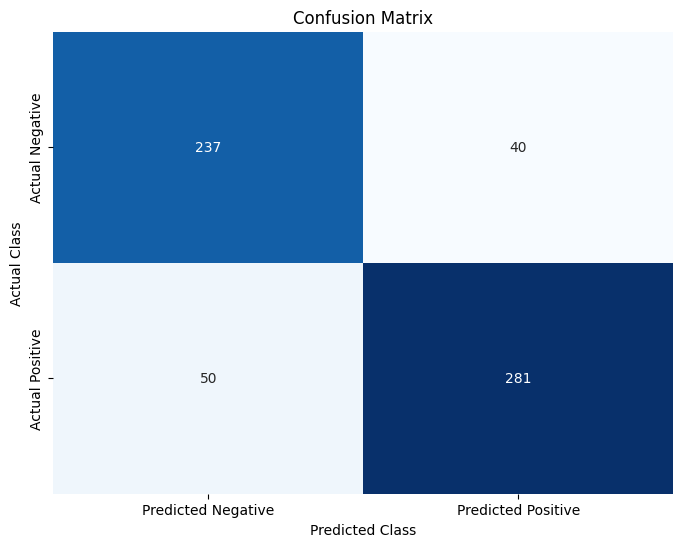

Accuracy: 0.8520
Precision: 0.8754
Recall: 0.8489


In [12]:
#--------------------------- Second Model Iteration: Deeper 7 Layer -----------------------------

input_size = X_train.shape[1]
model = DeeperNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "DeeperNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "DeeperNN")

# calculate and display classification metrics
D_accuracy, D_precision, D_recall = classification_metrics(y_test_class, test_predictions_class)

This deeper model expectedly performs much better than the simpler model. The loss ranges from about 422 ending at about 23 over the 1000 epochs. The learning curve is much more drastic than before, however the model also seems to plateau earlier than the model with less layers. One key note to make for the loss is that towards the end of the run, the training loss seems to start decreasing quicker than the testing loss. This is an indication of potential overfitting. This time, the heatmap graph is much more linear indicating a stronger correlation between predicted and actual life expectancnies suggesting that the model is definitely becoming more accurate. The root mean squared error was much lower at 4.79. This means that on average, the model's predictions deviate from the actual life expectancy by 4.79 years, about a 50% reduction from the initial model. Finally, the accuracy, precision, and recall all increased.

For the final, third iteration, I was curious as to how the model would be impacted if I implemented a higher lambda value/learning rate with the deeper 7 layer neural network. Everything in the process remained the same, except for the learning rate.

Epoch [100/1000], Train Loss: 51.2565, Test Loss: 51.3781
Epoch [200/1000], Train Loss: 21.7399, Test Loss: 26.0292
Epoch [300/1000], Train Loss: 17.2253, Test Loss: 22.9640
Epoch [400/1000], Train Loss: 14.9024, Test Loss: 20.8217
Epoch [500/1000], Train Loss: 13.3099, Test Loss: 19.4469
Epoch [600/1000], Train Loss: 18.0663, Test Loss: 20.7485
Epoch [700/1000], Train Loss: 12.8091, Test Loss: 19.1606
Epoch [800/1000], Train Loss: 11.4615, Test Loss: 18.8208
Epoch [900/1000], Train Loss: 11.2745, Test Loss: 18.9344
Epoch [1000/1000], Train Loss: 23.1964, Test Loss: 34.2932


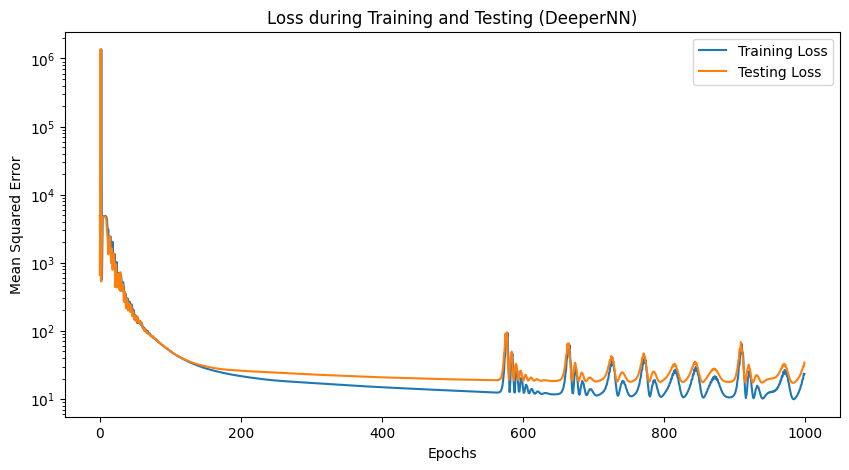

Train RMSE: 5.31
Test RMSE: 5.86


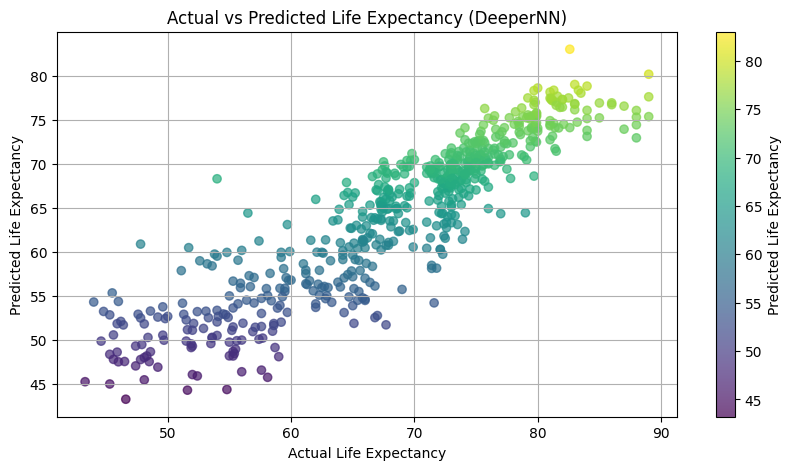

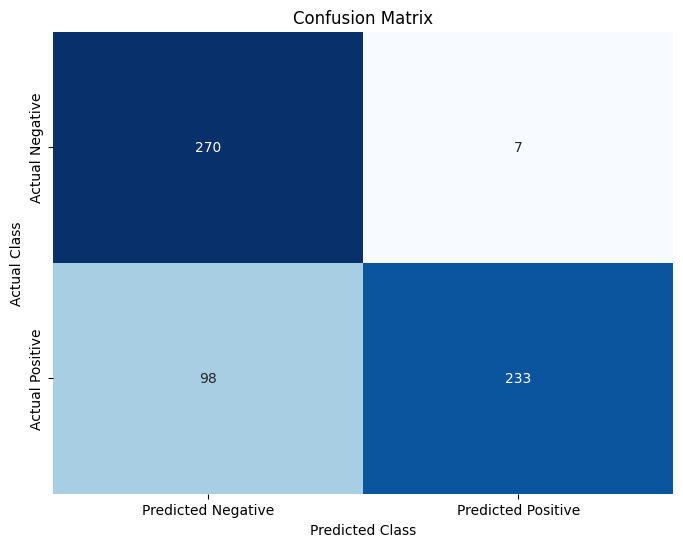

Accuracy: 0.8273
Precision: 0.9708
Recall: 0.7039


In [17]:
#--------------------------- Third Model Iteration: Deeper 7 Layer with High Lambda Value -----------------------------

input_size = X_train.shape[1]
model = DeeperNN(input_size)

# initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# train model
train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=1000)

# plot training and testing losses
plot_losses(train_losses, test_losses, "DeeperNN")

# evaluate model and get predictions
test_predictions, y_test_class, test_predictions_class = evaluate_model(model)

# plot actual vs predicted values
plot_actual_vs_predicted(y_test, test_predictions, "DeeperNN")

# calculate and display classification metrics
L_accuracy, L_precision, L_recall = classification_metrics(y_test_class, test_predictions_class)

This change induced interesting results. In regards to loss, there was a huge initial decrease to about 51 by the 100th epoch, but the loss curves seemed to stabalize after a bit suggesting that the model was converging. However, after convergence, we can see oscillations likely a result of the learning rate being too high causing the model to overshoot the weight adjustments. Looking at the heatmap graph, there's an identifiable linearity between the actual and predicted life expectancies. The testing RMSE was 5.86 meaning that on average the predicted life expectnacy deviated from the average life expectancy by 5.86 years. Finally, the accuracy, precision, and recall all decreased from the prior implementation.

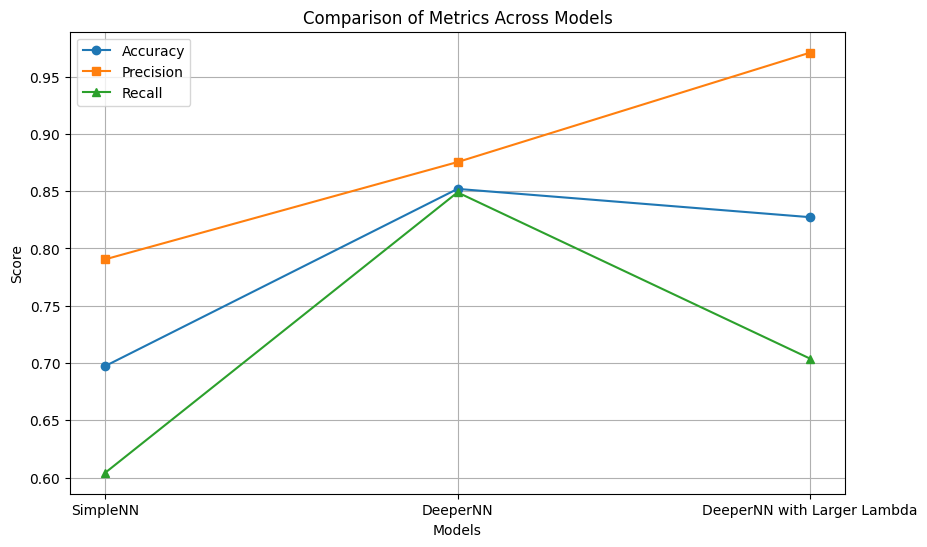

In [21]:
# display plot comapring accuracy precision and recall

# creating lines for each metric
accuracy = [S_accuracy, D_accuracy, L_accuracy]
precision = [S_precision, D_precision, L_precision]
recall = [S_recall, D_recall, L_recall]

# plotting
plt.figure(figsize=(10, 6))
models = ['SimpleNN', 'DeeperNN', 'DeeperNN with Larger Lambda']
plt.plot(models, accuracy, marker='o', label='Accuracy')
plt.plot(models, precision, marker='s', label='Precision')
plt.plot(models, recall, marker='^', label='Recall')
plt.title('Comparison of Metrics Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


As a final visualization and interpretation, I plotted the accuracy, precision, and recall comparing each model's metrics. In context, a higher accuracy means that the model is correctly predicting high and low life expectancies. A higher precision means that when the model predicts a high life expectancy (above 68.8 years), it is more likely to be correct. A higher recall means that the model is successfully identifying a larger proportion of actual high life expectancy cases.

As expected, the deeper neural network had a higher accuracy, precision, and recall than the simpler neural network, making it a more trustowrthy model. However, the deeper neural network with the larger learning rate had a higher precision, lower accuracy and lower recall than the deeper neural network. This is most likely because the higher learning rate caused the model to overshoot weights and become conservative with predicting high life expectancies. As shown by the model's confusion matrix, it made many more low than high life expectancy predictions. Thus, if it is making fewer positive predictions but those are mostly correct, precision improves. On the flip side, it's making more false negative predictions which results in a lower accuracy and espececially recall since recall is sensitive to false negatives.

# Conclusion
The deeper neural network emerged as the most reliable implementation of my model, achieving an accuracy of 85.2%, which falls within my defined threshold for effective performance (85-90%). Additionally, it recorded a precision of 87.5% and a recall of 84.89%, reflecting decent model performance overall.

However, the main limitation of both the training and testing datasets is their sample size. With only 2,849 entries, the dataset may hinder generalizability, introduce high variability, and potentially bias the model's results. To improve accuracy and robustness, a larger dataset—ideally around 30,000 entries—would be necessary. The current model may struggle to classify life expectancy accurately for populations not adequately represented in the data.

Given the model's effectiveness on the lower end of the threshold and the smaller sample size, I believe that without a larger dataset and more advanced algorithms, its practical utility is limited. However, addressing these limitations could significantly enhance the model's effectiveness. Once improved, life expectancy models could serve as valuable tools for policymakers and governments in designing health interventions, allocating budgets, and prioritizing specific regions or countries for aid. Additionally, the general public could leverage this information to advocate for changes that address barriers to improving life expectancy in their nations based on a thorough analysis of contributing factors.